In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle


class Experiments(object):
    def __init__(self, directory, reload_logs=False):
        self.directory = directory
        _, self.description = os.path.split(self.directory)
        self.all_experiment_names = os.listdir(self.directory)
        self.all_experiment_names = [e for e in self.all_experiment_names if
                                     os.path.isdir(os.path.join(self.directory, e))]
        self.experiments = [Experiment(os.path.join(self.directory, e),
                                       reload_log=reload_logs) for e in self.all_experiment_names]
        self.grouped_experiments = self.group_experiments()

    def group_experiments(self):
        groups = {}
        for e in self.experiments:
            if e.env_name not in groups:
                groups[e.env_name] = {}
            if e.method not in groups[e.env_name]:
                groups[e.env_name][e.method] = MultipleSeedsExperiment([])
            groups[e.env_name][e.method].add(e)
        return groups


class MultipleSeedsExperiment(object):
    def __init__(self, experiments):
        self.experiments = experiments

    def add(self, experiment):
        self.experiments.append(experiment)

    def get_xs_ys(self, y_series='eprew_recent'):
        list_of_xs, list_of_ys, n_steps_per_update = [], [], []
        for exp in self.experiments:
            if 'n_updates' in exp.log[0]:
                list_of_xs.append(exp.timeseries('n_updates'))
                list_of_ys.append(exp.timeseries(y_series))
                n_steps_per_update.append(exp.timeseries('tcount')[-1] / exp.timeseries('n_updates')[-1])
            else:
                list_of_xs.append(exp.timeseries('tcount'))
                list_of_ys.append(exp.timeseries(y_series))
                n_steps_per_update.append(1)
        x, y = group_timeseries(list_of_xs, list_of_ys)
        return x * np.max(n_steps_per_update), y

class Experiment(object):
    log_separator = '------------'

    def __init__(self, directory, reload_log):
        self.directory = directory
        _, self.exp_name = os.path.split(self.directory)
        self.env_name, self.method, self.seed = self.parse_name(name=self.exp_name)
        self.log = self.load_log(regenerate=reload_log)
        # self.exp_details = self.load_exp_info()
        self._timeseries = {}

    def parse_name(self, name):
        if name.startswith('mariogen'):
            return self.parse_name_mariogen(name)
        elif name == 'mz8gpu':
            return 'MontezumaRevenge', 'idf', 0
        elif name == 'mario16gpurf-00':
            return 'Mario', 'rf_large', 0
        elif name == 'mario1gpurf':
            return 'Mario', 'rf_small', 0
        else:
            if '_' in self.exp_name:
                return self.parse_name_yura_convention(name)
            else:
                return self.parse_name_harri_convention(name)


    def parse_name_yura_convention(self, name):
        env, method, seed, *extra = name.split('_')
        if method == 'randfeat':
            method = 'rf'
        if extra != []:
            method += '_' + '_'.join(extra)
        return env, method, seed

    def parse_name_harri_convention(self, name):
        envs = {'mz': 'MontezumaRevenge',
                'mario': 'Mario',
                'breakout': 'Breakout',
                'pong': 'Pong',
                'spaceinvaders': 'SpaceInvaders',
                'qbert': 'Qbert',
                'beamrider': 'BeamRider',
                'riverraid': 'Riverraid',
                'seaquest': 'Seaquest',
                'unitysparse': 'Unity-Sparse',
                'unitytv0': 'Unity-TV0',
                'unitytv2': 'Unity-TV2',
                'multipong': "Multiplayer-Pong",
                'juggling': "Roboschool-Juggling"
                }
        methods = ['vaesph', 'pix2pixbn', 'pix2pix', 'idfbnnontrainable', 'idfbntrainable', 'idf', 'rf', 'vaenonsph',
                   'randfeatbn', 'ext','lbs']  # the order matters
        method = [m for m in methods if m in name]
        method = method[0]
        seed = int(name[-1]) - 1
        env = name[:-(1 + len(method))]
        env = envs[env]
        return env, method, seed

    def parse_name_mariogen(self, name):
        name = name[len('mariogen'):]
        env = 'MarioGen'
        if name.startswith('fixed'):
            extra_method = '_fixed'
            name = name[len('fixed'):]
        else:
            extra_method = ''
        method = name[:len('1to1')]
        name = name[len('1to1'):]
        assert name.startswith('idf') or name.startswith('rf'), self.directory
        if name.startswith('idf'):
            feat_method = 'idf'
        elif name.startswith('rf'):
            feat_method = 'rf'
        method += '_{}'.format(feat_method)
        method += extra_method
        name = name[len(feat_method):]
        seed = int(name) - 1
        return env, method, seed

    def load_exp_info(self):
        directory = os.path.join(self.directory, 'exp_details.pkl')
        if os.path.exists(directory):
            with open(directory, 'rb') as f:
                try:
                    exp_details = pickle.load(f)
                    if not exp_details:
                        exp_details = None
                except:
                    exp_details = None
        else:
            exp_details = None
        return exp_details

    def load_log(self, regenerate=False):
        pickle_of_log = os.path.join(self.directory, 'log.pickle')
        if os.path.exists(pickle_of_log) and not regenerate:
            with open(pickle_of_log, 'rb') as f:
                print('loading log ', pickle_of_log)
                log = pickle.load(f)
        else:
            print('parsing log {}'.format(self.directory))
            log_file = os.path.join(self.directory, 'log.txt')

            log = self.parse_log_from_file(log_file)
            with open(pickle_of_log, 'wb') as f:
                pickle.dump(log, f, protocol=-1)
        return log

    def parse_log_from_file(self, log_file):
        with open(log_file, 'r') as f:
            lines = f.readlines()
        lines = [l.strip() for l in lines if l.startswith('|') or l.startswith(Experiment.log_separator)]
        chunks = []
        current_chunk = {}
        for l in lines:
            if l.startswith(Experiment.log_separator):
                if current_chunk != {}:  # end of chunk
                    chunks.append(current_chunk)
                current_chunk = {}
            else:
                name, value = [p.strip() for p in l.split('|') if p.strip() != '']
                try:
                    if value != 'nan':
                        value = eval(value)
                    else:
                        value = np.nan
                except:
                    print(name, value, "failed")
                current_chunk[name] = value
        return chunks

    def timeseries(self, name):
        assert self.log is not None
        if self._timeseries.get(name, None) is None:
            self._timeseries[name] = [entry.get(name, 0.) for entry in self.log]
        return self._timeseries[name]

    def __str__(self):
        return self.exp_name

def group_timeseries(list_of_xs, list_of_ys):
    grouped_values = {}
    for xs, ys in zip(list_of_xs, list_of_ys):
        for x, y in zip(xs, ys):
            if x not in grouped_values:
                grouped_values[x] = []
            if y is None:
                y = np.nan
            grouped_values[x].append(y)
    # take the intersection
    xs = []
    ys = []
    for x in grouped_values:
        v = grouped_values[x]
        assert len(v) <= len(list_of_ys)
        if len(v) == len(list_of_ys):
            xs.append(x)
            ys.append(v)
    return np.asarray(xs), np.asarray(ys)

def smooth(x, extent):
    from scipy import signal
    if extent is not 0:
        return signal.savgol_filter(np.nan_to_num(x), extent,
                                    3)  # TODO: change the smoothing back to 101 when all the datapoints are in
    else:
        return np.nan_to_num(x)


class AxesWithPlots(object):
    def __init__(self, ax):
        self.ax = ax
        self.max_xs = []
        self.lines = []

    def add_std_plot(self, x, y, color, label, smoothen=51, alpha=1., std_alpha=0.1, frames_per_timestep=4, clip=None):
        x *= frames_per_timestep
        x /= 1e6
        if smoothen != 0:
            y = np.stack([smooth(y[:, i], extent=smoothen) for i in range(y.shape[1])], 1)
            if clip is not None:
                y = np.clip(y, clip[0], clip[1])
        mean_y = np.mean(y, 1)

        self.lines.extend(self.ax.plot(x, mean_y, color=color, label=label, alpha=alpha))
        if y.shape[1] > 1:
            std_y = np.std(y, 1, ddof=1)
            upper = mean_y + std_y / np.sqrt(y.shape[1])
            lower = mean_y - std_y / np.sqrt(y.shape[1])
            self.ax.fill_between(x, upper, lower, color=color, alpha=std_alpha, lw=0.)

        self.max_xs.append(x[-1])

    def finish_up(self, title, fontsize=12, xlim=400, tight_y=True):
        self.ax.set_xlim([0, min(xlim, max(*self.max_xs))])
        self.ax.set_title(title, fontsize=fontsize)
        self.ax.autoscale(enable=True, axis='y', tight=tight_y)


colors = {'idf': '#f7ae54',
          'idf_3epochs': 'orange',
          'idf_6epochs': 'red',
          'vaesph': '#6394be',
          'rf': '#61a956',
          'rf_6epochs': 'seagreen',
          'rf_3epochs': 'black',
          'extrew': 'gray',
          'ext': 'gray',
          'pix2pix': 'lightcoral',
          'lbs': '#ec5049',
          }
labels = {'idf': 'IDF model',
          'idf_3epochs': 'Inverse Dynamics features 3 ep',
          'idf_6epochs': 'Inverse Dynamics features',
          'pix2pix': 'Pixels',
          'rf': 'RF model',
          'rf_3epochs': 'Random CNN features 3 ep',
          'rf_6epochs': 'Random CNN features',
          'extrew': 'Extrinsic rewards',
          'ext': 'Extrinsic rewards',
          'vaesph': 'VAE model',
          'lbs': 'LBS (ours)',
          }


def generate_three_seed_graphs(three_seed_exps, y_series='eprew_recent', smoothen=51, alpha=1.0):
    num_envs = len(three_seed_exps.grouped_experiments)
    print(num_envs)
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, figsize=(12, 6))
    all_axes = []
    envs = [env for env in three_seed_exps.grouped_experiments if env not in ['Unity-Sparse']]
    envs = ['BeamRider', 'Breakout', 'MontezumaRevenge', 'Pong', 'Mario', 'Qbert', 'Riverraid', 'Seaquest', 'SpaceInvaders']
    # envs.remove('Mario')
    for env, ax in zip(envs, np.ravel(axes)):
        # import ipdb; ipdb.set_trace()
        ax.tick_params(labelsize=10, pad=0.001)
        ax.grid(axis='y', linestyle='dashed')
        ax_with_plots = AxesWithPlots(ax)
        all_axes.append(ax_with_plots)
        print(env)
        for method in three_seed_exps.grouped_experiments[env]:
            if method != 'extrew':
                # print("generating graph ", env, method)
                xs, ys = three_seed_exps.grouped_experiments[env][method].get_xs_ys(y_series)
                xs = xs.astype('float')
                ys = ys.astype('float')
                ax_with_plots.add_std_plot(xs, ys, color=colors[method], label=labels[method], smoothen=smoothen,
                                           alpha=alpha)
                
                y_smooth = np.stack([smooth(ys[:, i], extent=smoothen) for i in range(ys.shape[1])], 1)
                mean_y_smooth = np.mean(y_smooth, 1)
                std_y_smooth = np.std(y_smooth, 1)
                index = [i for i, x in enumerate(xs) if np.round(x,0) == 400][0]
                print(method, np.round(mean_y_smooth[index-50:index].mean(),2), '±', np.round(std_y_smooth[index-50:index].mean(), 2))
                
        ax_with_plots.finish_up(title=env)
    axes[1,4].set_visible(False)
    # fig.set_xlabel('Number of training steps (in millions)', fontsize=14)
    # fig.set_ylabel('Extrinsic Rewards per Episode', fontsize=14)
    plt.tight_layout(pad=1.5, w_pad=-0.3, h_pad=0.3, rect=[0.01, 0.01, 1, 1])
    # plt.tight_layout()
    ordered_lines = [all_axes[0].lines[0], all_axes[0].lines[2], all_axes[0].lines[1], all_axes[0].lines[3]]
    fig.legend(handles=ordered_lines, borderaxespad=0., fontsize=10, loc=(0.82,0.2), ncol=1)
    fig.text(0.43, 0.01, 'Frames (millions)', ha='center', fontsize=12)
    fig.text(0.007, 0.5, 'Sum of Extrinsic Rewards per Episode', va='center', rotation='vertical', fontsize=12)
    save_filename = os.path.join(results_folder, 'three_seeds_{}.png'.format(y_series))
    print("saving ", save_filename)
    plt.savefig(save_filename, dpi=300)
    return fig, all_axes

    # plt.close()

def generate_three_seed_graphs_mario(three_seed_exps, y_series='eprew_recent', smoothen=51, alpha=1.0):
    num_envs = len(three_seed_exps.grouped_experiments)
    print(num_envs)
    fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True)
    all_axes = []
    envs = [env for env in three_seed_exps.grouped_experiments if env in ['Mario']]
    for env, ax in zip(envs, np.ravel(axes)):
        # import ipdb; ipdb.set_trace()
        ax.tick_params(labelsize=4, pad=0.001)
        ax_with_plots = AxesWithPlots(ax)
        all_axes.append(ax_with_plots)
        for method in three_seed_exps.grouped_experiments[env]:
            if method != 'extrew':
                print("generating graph ", env, method)
                xs, ys = three_seed_exps.grouped_experiments[env][method].get_xs_ys(y_series)
                ax_with_plots.add_std_plot(xs, ys, color=colors[method], label=labels[method], smoothen=smoothen,
                                           alpha=alpha)
        ax_with_plots.finish_up(title=env)
    # fig.set_xlabel('Number of training steps (in millions)', fontsize=14)
    # fig.set_ylabel('Extrinsic Rewards per Episode', fontsize=14)
    plt.tight_layout(pad=1.5, w_pad=-0.3, h_pad=0.3, rect=[0.01, 0., 1, 1])
    # plt.tight_layout()
    fig.legend(handles=all_axes[0].lines, borderaxespad=0., fontsize=10, loc='upper center', ncol=2)
    fig.text(0.5, 0.01, 'Frames (millions)', ha='center')
    fig.text(0.007, 0.5, 'Extrinsic Reward per Episode', va='center', rotation='vertical')
    save_filename = os.path.join(results_folder, 'three_seeds_mario_{}.png'.format(y_series))
    print("saving ", save_filename)
    plt.savefig(save_filename, dpi=300)
    plt.close()


def generate_three_seed_graphs_unity(three_seed_exps, y_series='eprew_recent', smoothen=51, alpha=1.0):
    num_envs = len(three_seed_exps.grouped_experiments)
    print(num_envs)
    fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True)
    all_axes = []
    envs = [env for env in three_seed_exps.grouped_experiments if env in ['Unity-Sparse']]
    for env, ax in zip(envs, np.ravel(axes)):
        # import ipdb; ipdb.set_trace()
        ax.tick_params(labelsize=12, pad=0.001)
        ax_with_plots = AxesWithPlots(ax)
        all_axes.append(ax_with_plots)
        for method in three_seed_exps.grouped_experiments[env]:
            print("generating graph ", env, method)
            xs, ys = three_seed_exps.grouped_experiments[env][method].get_xs_ys(y_series)
            ax_with_plots.add_std_plot(xs, ys, color=colors[method], label=labels[method], smoothen=smoothen,
                                       alpha=alpha, frames_per_timestep=1, clip=[0.,1.])
        ax_with_plots.finish_up(title=env, tight_y=False, fontsize=18)
        ax_with_plots.ax.set_xlim([0, 7])
    # fig.set_xlabel('Number of training steps (in millions)', fontsize=14)
    # fig.set_ylabel('Extrinsic Rewards per Episode', fontsize=14)
    plt.tight_layout(pad=1.5, w_pad=-0.3, h_pad=0.3, rect=[0.01, 0.01, 1, 0.89])
    # plt.tight_layout()
    fig.legend(handles=all_axes[0].lines, borderaxespad=0., fontsize=12, loc='upper center', ncol=2)
    fig.text(0.5, 0.01, 'Frames (millions)', ha='center', fontsize=18)
    fig.text(0.007, 0.5, 'Extrinsic Reward per Episode', va='center', rotation='vertical', fontsize=18)
    save_filename = os.path.join(results_folder, 'three_seeds_unity_{}.png'.format(y_series))
    print("saving ", save_filename)
    plt.savefig(save_filename, dpi=300)
    plt.close()

def generate_one_seed_graphs(one_seed_exps, y_series='eprew_recent'):
    num_envs = len(one_seed_exps.grouped_experiments)
    print(num_envs)
    fig, axes = plt.subplots(nrows=6, ncols=8, sharex=True)
    all_axes = []
    envs = [env for env in one_seed_exps.grouped_experiments if env not in ['Mario', 'Unity-Sparse']]
    for env, ax in zip(envs, np.ravel(axes)):
        # import ipdb; ipdb.set_trace()
        ax.tick_params(labelsize=4, pad=0.001)
        ax_with_plots = AxesWithPlots(ax)
        all_axes.append(ax_with_plots)
        for method in one_seed_exps.grouped_experiments[env]:
            if method != 'extrew' and '3epochs' not in method:
                print("generating graph ", env, method)
                xs, ys = one_seed_exps.grouped_experiments[env][method].get_xs_ys('eprew_recent')
                ax_with_plots.add_std_plot(xs, ys, color=colors[method], label=labels[method], smoothen=201)
        rand_agent_results_filename = os.path.join(results_folder, 'rand_agent', '{}_randagent_0'.format(env), 'log.txt')
        with open(rand_agent_results_filename, 'r') as f:
            rand_info = f.readlines()[-1]
            try:
                step, mean_r, best_r, worst_r = rand_info.split(':')
            except:
                print(env)
                step, mean_r, best_r = rand_info.split(':')
            mean_r = float(mean_r)
            best_r = float(best_r)
            # worst_r = float(worst_r)
        rand_ag_line = ax.axhline(mean_r, label='Random agent', color='blue')
        ax.set_title(env, fontsize=4)
        ax.autoscale(enable=True, axis='y', tight=False)
        ax.set_xlim([0, 400])
    # fig.set_xlabel('Number of training steps (in millions)', fontsize=14)
    # fig.set_ylabel('Extrinsic Rewards per Episode', fontsize=14)
    plt.tight_layout(pad=1.5, w_pad=-0.3, h_pad=0.3, rect=[0.01, 0., 1, 0.925])
    # plt.tight_layout()
    fig.legend(handles=all_axes[0].lines+[rand_ag_line], borderaxespad=0., fontsize=10, loc='upper center', ncol=2)
    fig.text(0.5, 0.01, 'Frames (millions)', ha='center')
    fig.text(0.007, 0.5, 'Extrinsic Reward per Episode', va='center', rotation='vertical')
    save_filename = os.path.join(results_folder, 'one_seed_{}.png'.format(y_series))
    print("saving ", save_filename)
    plt.savefig(save_filename, dpi=300)
    plt.close()

def generate_one_seed_aggregate_graph(one_seed_exps, y_series='eprew_recent'):
    num_envs = len(one_seed_exps.grouped_experiments)
    print(num_envs)
    all_better = {}
    # all_number = 0
    envs = [env for env in one_seed_exps.grouped_experiments if env not in ['Mario', 'Unity-Sparse']]
    all_better['comp'] = {'xs': [], 'ys': []}
    for env in envs:
        rand_agent_results_filename = os.path.join(results_folder, 'rand_agent', '{}_randagent_0'.format(env),
                                                   'log.txt')
        with open(rand_agent_results_filename, 'r') as f:
            rand_info = f.readlines()[-1]
            try:
                step, mean_r, best_r, worst_r = rand_info.split(':')
            except:
                print(env)
                step, mean_r, best_r = rand_info.split(':')
            mean_r = float(mean_r)
        for method in one_seed_exps.grouped_experiments[env]:
            if method != 'extrew' and '3epochs' not in method:
                print("generating graph ", env, method)
                xs, ys = one_seed_exps.grouped_experiments[env][method].get_xs_ys('eprew_recent')
                if method not in all_better:
                    all_better[method] = {'xs': [], 'ys': [], 'raw_ys': []}
                all_better[method]['xs'].append(xs)
                all_better[method]['ys'].append(ys > mean_r)
                all_better[method]['raw_ys'].append(ys.copy())
        all_better['comp']['xs'].append(all_better['rf_6epochs']['xs'][-1])
        idf_y = all_better['idf_6epochs']['raw_ys'][-1]
        rf_y = all_better['rf_6epochs']['raw_ys'][-1]
        cmn = min(idf_y.shape[0], rf_y.shape[0])
        all_better['comp']['ys'].append(rf_y[:cmn] > idf_y[:cmn])

    for method in all_better:
        # if 'rf' in method:
        n_common_pts = np.min([y.shape[0] for y in all_better[method]['ys']])
        print(n_common_pts)
        plot_y = np.asarray([y[:n_common_pts, 0] for y in all_better[method]['ys']])
        plt.plot(all_better[method]['xs'][0][:n_common_pts], smooth(np.mean(plot_y, 0), 51))
        plt.show()


# generate_one_seed_aggregate_graph(one_seed_exps)

def generate_mario_graphs(mario_exps, y_series='eprew_recent'):
    colors = {'idf_baseline': 'orange',
              'idf_transfer': 'lightcoral',
              'rf_baseline': 'seagreen',
              'rf_transfer': 'cornflowerblue', #"turquoise"
              # 'idf_fixed_baseline': 'yellow',
              # 'idf_fixed_transfer': 'green',
              }
    labels = {'idf_baseline': 'IDF scratch',
              'idf_transfer': 'IDF transfer',
              'rf_baseline': 'RF scratch',
              'rf_transfer': 'RF transfer',
              'idf_fixed_baseline': 'IDF fixed baseline',
              'idf_fixed_transfer': 'IDF fixed transfer',
              }

    gen_directions = [(1, 2), (1, 3)]
    # gen_directions = [(1, 3)]
    fig, axes = plt.subplots(nrows=1, ncols=len(gen_directions), sharex=True)
    all_axes = []
    exps = mario_exps.grouped_experiments['MarioGen']
    for gen_direction, ax in zip(gen_directions, np.ravel(axes)):
        ax.tick_params(labelsize=8, pad=0.001)
        ax_with_plots = AxesWithPlots(ax)
        all_axes.append(ax_with_plots)
        print("generating graph mariogen", '{}to{}'.format(*gen_direction))
        for method in ['idf', 'rf']:
            method_baseline = '{}to{}'.format(gen_direction[1], gen_direction[0]) + '_' + method
            if method_baseline in exps:
                xs_baseline, ys_baseline = exps[method_baseline].get_xs_ys(y_series)
                xs_baseline, ys_baseline = xs_baseline[10:xs_baseline.shape[0] // 2-10], ys_baseline[10:ys_baseline.shape[0] // 2-10]

                method_transfer = '{}to{}'.format(gen_direction[0], gen_direction[1]) + '_' + method
                xs_transfer, ys_transfer = exps[method_transfer].get_xs_ys(y_series)
                first_x = xs_transfer[xs_transfer.shape[0] // 2]
                xs_transfer, ys_transfer = xs_transfer[xs_transfer.shape[0] // 2+10:-10], ys_transfer[ys_transfer.shape[0] // 2+10:-10]
                xs_transfer -= first_x

                method_baseline_key = method + '_' + 'baseline'
                method_transfer_key = method + '_' + 'transfer'
                ax_with_plots.add_std_plot(xs_baseline, ys_baseline, color=colors[method_baseline_key],
                                           label=labels[method_baseline_key], smoothen=51, std_alpha=0.2)
                ax_with_plots.add_std_plot(xs_transfer, ys_transfer, color=colors[method_transfer_key],
                                           label=labels[method_transfer_key],
                                           smoothen=51, std_alpha=0.2)
        image = os.path.join(results_folder, 'mario-{}-1.gif').format(gen_direction[1])
        from PIL import Image
        image = Image.open(image)
        ax_with_plots.ax.imshow(image, extent=(0,40,0,150), aspect='auto')
        image = os.path.join(results_folder, 'mario-1-1.gif')
        image = Image.open(image)
        ax_with_plots.ax.imshow(image, extent=(0, 40, 220, 370), aspect='auto')
        # ax.text(20, 185, "TO", fontdict={"size": 5})
        ax.arrow(20, 212, 0, -30, width=5, facecolor='k')
        ax_with_plots.finish_up(title='World {} level 1 to world {} level 1'.format(*gen_direction), fontsize=10)
    # fig.set_xlabel('Number of training steps (in millions)', fontsize=14)
    # fig.set_ylabel('Extrinsic Rewards per Episode', fontsize=14)
    plt.tight_layout(pad=1.5, w_pad=0., h_pad=0.3, rect=[0.01, 0., 1, 0.925])
    # plt.tight_layout()
    fig.legend(handles=all_axes[0].lines, borderaxespad=0., fontsize=10, loc='upper center', ncol=2)
    fig.text(0.5, 0.01, 'Frames (millions)', ha='center')
    fig.text(0.007, 0.5, 'Extrinsic Reward per Episode', va='center', rotation='vertical')
    save_filename = os.path.join(results_folder, 'mario_transfer_{}_non_fixed.pdf'.format(y_series))
    print("saving ", save_filename)
    plt.savefig(save_filename, dpi=1200)
    plt.close()

<>:214: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:214: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-1-b7fecddbc3b4>:214: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if extent is not 0:


In [2]:
results_folder = os.path.expanduser('./')
results_folder = './experiments'
three_seed_exps = Experiments(os.path.join(results_folder, 'three_seed_main_envs'), reload_logs=False)

loading log  ./experiments/three_seed_main_envs/unitysparserf1/log.pickle
loading log  ./experiments/three_seed_main_envs/MontezumaRevenge_vaesph_2/log.pickle
loading log  ./experiments/three_seed_main_envs/Qbert_vaesph_0/log.pickle
loading log  ./experiments/three_seed_main_envs/MontezumaRevenge_lbs_0/log.pickle
loading log  ./experiments/three_seed_main_envs/Qbert_extrew_0/log.pickle
loading log  ./experiments/three_seed_main_envs/BeamRider_lbs_0/log.pickle
loading log  ./experiments/three_seed_main_envs/breakoutidf2/log.pickle
loading log  ./experiments/three_seed_main_envs/pongrf2/log.pickle
loading log  ./experiments/three_seed_main_envs/seaquestrf3/log.pickle
loading log  ./experiments/three_seed_main_envs/marioidf1/log.pickle
loading log  ./experiments/three_seed_main_envs/beamriderrf2/log.pickle
loading log  ./experiments/three_seed_main_envs/riverraidrf1/log.pickle
loading log  ./experiments/three_seed_main_envs/unitysparseext2/log.pickle
loading log  ./experiments/three_seed_

loading log  ./experiments/three_seed_main_envs/seaquestidf2/log.pickle
loading log  ./experiments/three_seed_main_envs/SpaceInvaders_lbs_1/log.pickle
loading log  ./experiments/three_seed_main_envs/Breakout_vaesph_0/log.pickle
loading log  ./experiments/three_seed_main_envs/Pong_lbs_2/log.pickle
loading log  ./experiments/three_seed_main_envs/SpaceInvaders_lbs_0/log.pickle
loading log  ./experiments/three_seed_main_envs/mzrf2/log.pickle
loading log  ./experiments/three_seed_main_envs/Seaquest_lbs_0/log.pickle
loading log  ./experiments/three_seed_main_envs/Seaquest_vaesph_1/log.pickle


10
BeamRider
lbs 2658.89 ± 286.15
rf 1803.47 ± 251.03
idf 1710.22 ± 98.46
vaesph 3250.04 ± 88.69
Breakout
idf 91.56 ± 19.91
lbs 359.16 ± 9.72
rf 165.22 ± 51.03
vaesph 205.6 ± 19.95
MontezumaRevenge
vaesph 86.8 ± 62.03
lbs 0.0 ± 0.0
rf 254.49 ± 180.47
idf 0.0 ± 0.0
Pong
rf -5.98 ± 0.32
vaesph -18.83 ± 3.07
idf -6.64 ± 4.1
lbs -0.79 ± 0.65
Mario
idf 4178.44 ± 175.25
vaesph 5510.54 ± 276.71
rf 5609.67 ± 470.26
lbs 5167.91 ± 335.71
Qbert
vaesph 2232.05 ± 225.73
lbs 8865.92 ± 793.8
rf 3774.58 ± 408.27
idf 4691.61 ± 286.28
Riverraid
rf 4498.68 ± 146.48
lbs 4710.84 ± 516.87
idf 5296.04 ± 464.52
vaesph 4958.37 ± 90.99
Seaquest
rf 433.05 ± 65.54
vaesph 439.36 ± 27.28
idf 530.49 ± 20.12
lbs 623.06 ± 31.14
SpaceInvaders
idf 615.47 ± 41.11
lbs 534.23 ± 78.03
vaesph 737.23 ± 28.08
rf 599.44 ± 41.19
saving  ./experiments/three_seeds_eprew_recent.png


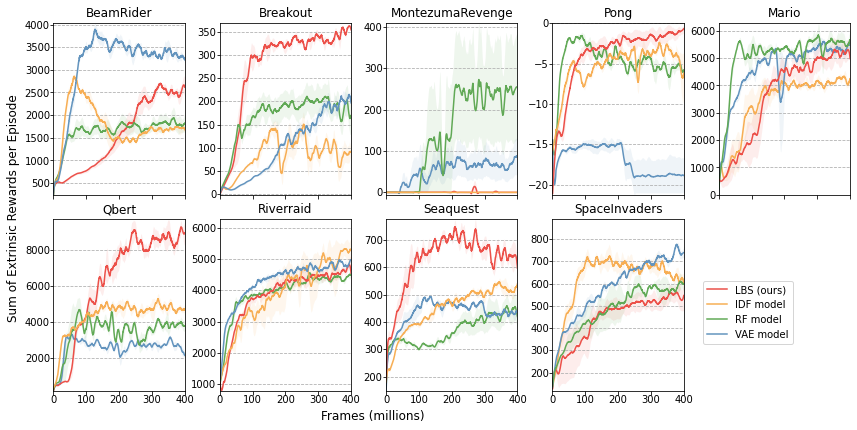

In [3]:
fig, all_axes = generate_three_seed_graphs(three_seed_exps, 'eprew_recent', smoothen=301)